In [2]:
#import everything
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import urllib2
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
from bs4.diagnose import diagnose
from lxml import etree
import requests
import bs4

# Fetch world population statistics from Wikipedia
**In this excercise, Wikipedia's population statistics will be parsed, cleaned and analysed.

    1) Import the html and create a BS tree

In [3]:
url = ('https://en.wikipedia.org/wiki/List_of_countries_by_past,_current_and_future_population')
def get_site_html(url):
    source = urllib2.urlopen(url).read()
    return source
def get_tree(url):
    source = get_site_html(url)
    soup = BeautifulSoup(source, 'lxml')
    return soup
soup = get_tree(url)

    2) Extract the data from the tables and fill a DataFrame

In [4]:
table_one = []
for td in soup.find_all('table')[0]:
    try:
        table_one.append(td.stripped_strings)
    except:
        pass
table_one = DataFrame(table_one)
# Clean up=======================
garbage_cols = range(4,15,2)
table_one.drop(garbage_cols, axis=1, inplace = True)
table_one = table_one.drop(0, axis=1)
# Rename the headers
table_one.rename(columns={1:'Country',2:'1950', 3:'1955', 5:'1960', 7:'1965', 9:'1970', 11:'1975', 13:'1980'}, inplace=True)
# Make the column 1 the index
table_one = table_one.set_index('Country')
# Delete the first row
table_one = table_one[1:229]
table_one.replace('', np.nan, inplace=True)
#table_one.head(5)

In [23]:
# Scrape the second table
#-------------------------
table_two = []
for td in soup.find_all('table')[1]:
    try:
        table_two.append(td.stripped_strings)
    except:
        pass
table_two = DataFrame(table_two)
# Cleanup
table_two.drop([0,3,5,7,9,11,13,15], axis=1, inplace=True) # deletes unwanted columns
table_two.rename(columns={1:'Country',2:'1985', 4:'1990', 6:'1995', 8:'2000', 10:'2005', 12:'2010', 14:'2015'}, inplace=True)
table_two = table_two[1:229]
table_two = table_two.set_index('Country')
# The first row has garbage (years) which must be replaced with nothing in the cells.
#table_two.head(4)

    3) Concatenate the tables

In [24]:
len(table_one)==len(table_two)
mydata = pd.concat([table_one, table_two], axis=1)

    4) Convert the unicode values to 'float'

In [25]:
def convert_to_float(x):
    try:
        # Replace commas and convert to float
        return float(x.replace(',', ''))
    except:
        # There is some cell with a % sign in it, so just return instead of failing
        return x

# Apply the above function to every cell via applymap
mydata = mydata.applymap(convert_to_float)
#mydata.head(3)

## Do some plots

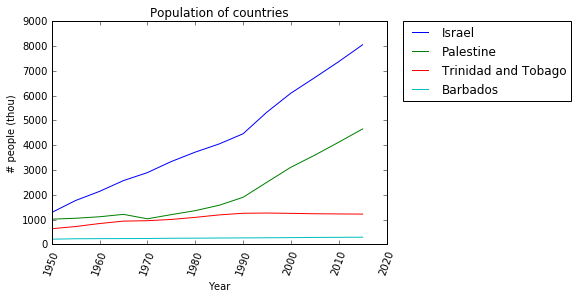

In [26]:
plotCountries = ['Israel', 'Palestine', 'Trinidad and Tobago', 'Barbados']
    
for country in plotCountries:
    row = mydata.ix[country]
    plt.plot(row.index, row, label=row.name ) 
    
plt.ylim(ymin=0) # start y axis at 0

plt.xticks(rotation=70)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Year")
plt.ylabel("# people (thou)")
plt.title("Population of countries")

## Plot the population trends for 
#### 1) The top most populated countries
#### 2) The 10 least populated countries
#### 3) Determine which countries have had the least population change and plot them
#### 4) Which countries have increased the most positive population change? Plot them

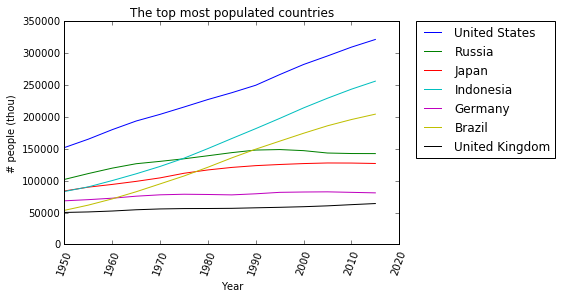

In [27]:
##### Determine which countries have the most people
# A good way to do that would be to average across each row, store that vector and sort
maxpop = mydata.sort_values(['1950','1955','1960'],ascending=[False,False,False])
# sorts population according to the year 1950
maxPopCountries = maxpop.index[3:10]
for country in maxPopCountries:
    row = maxpop.ix[country]
    plt.plot(row.index, row, label=row.name ) 
    
plt.ylim(ymin=0) # start y axis at 0
plt.xticks(rotation=70)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Year")
plt.ylabel("# people (thou)")
plt.title("The top most populated countries")

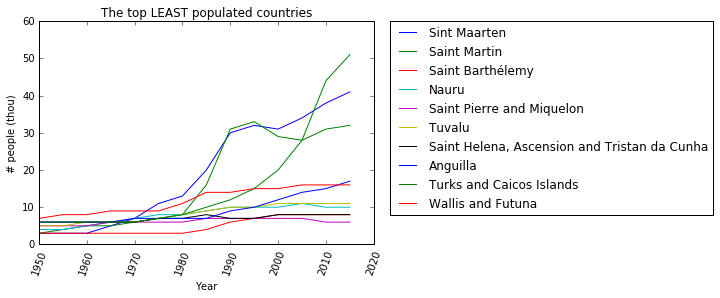

In [10]:
# The least populated countries are then found via:
minpop = mydata.sort_values(['1950'],ascending=[True])
minpopcountries = minpop.index[:10]
for country in minpopcountries:
    row = minpop.ix[country]
    plt.plot(row.index, row, label=row.name)
plt.ylim(ymin=0) # start y axis at 0
plt.xticks(rotation=70)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Year")
plt.ylabel("# people (thou)")
plt.title("The top LEAST populated countries")

## Determine the countries with the highest rate of growth

One way to determine the highest rate of increase is to assume a linear fit of the points and determine the gradient. Storing these gradients in a new vector will yeild the top 20 highest rates of increase. The next step then is to plot by those keys from the original dataframe

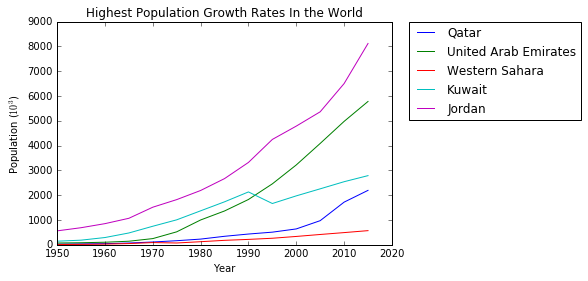

In [101]:
mydata['gradient']=((mydata['2015'] - mydata['1950'])/mydata['1950'])
#mydata.head()
# sort by gradient
top_pop_increase = mydata.sort_values(['gradient'], ascending=False)
#top_pop_increase.head()
# plot the top 10 vs the last 10
top_pop_increase =  top_pop_increase.drop('gradient',1)
rate_compare = top_pop_increase.index[0:5]
for country in rate_compare:
    row = top_pop_increase.ix[country]
    plt.plot(row.index, row, label=row.name)
plt.xlabel('Year')
plt.ylabel('Population ($10^3$)')
plt.title('Highest Population Growth Rates In the World')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

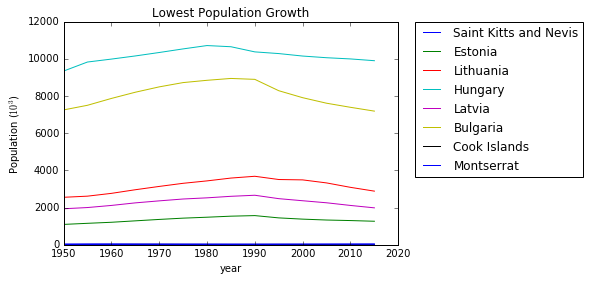

In [104]:
# Plot the least population growth
small_growth_countries = top_pop_increase.index[-8:]
for country in small_growth_countries:
    row = top_pop_increase.ix[country]
    plt.plot(row.index, row, label=row.name)
plt.xlabel('year')
plt.ylabel('Population ($10^3$)')
plt.title('Lowest Population Growth')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

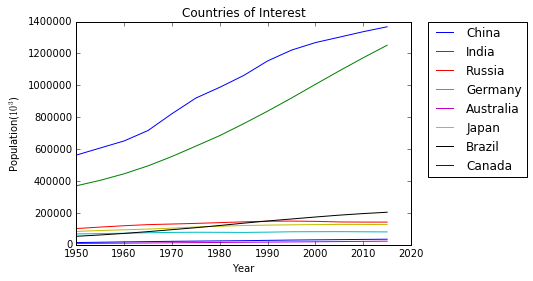

In [107]:
countries_of_interest = ['China', 'India', 'Russia', 'Germany', 'Australia', 'Japan','Brazil', 'Canada']
for country in countries_of_interest:
    row = top_pop_increase.ix[country]
    plt.plot(row.index, row, label=row.name)
plt.xlabel('Year')
plt.ylabel('Population($10^3$)')
plt.title('Countries of Interest')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)